In [1]:
# info...

# 1. Dane **yelp_review_polarity_csv/train.csv** https://www.kaggle.com/datasets/ilhamfp31/yelp-review-dataset/data
# 2.  Negative polarity is class 1, and positive class 2




In [2]:
!pwd
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP')

/content
Mounted at /content/drive


In [3]:
!pip install -U spacy==3.7.2 | grep -v 'already'
!python -m spacy download en_core_web_md  | grep -v 'already'

2024-01-04 11:26:26.541173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 11:26:26.548117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 11:26:26.550211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 11:26:26.567908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 11:26:29.668526: W tensorflow/compiler/tf2

In [4]:
import matplotlib.pyplot as P
import spacy
import re # wyrażenia regularne
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
!pwd

/content/drive/My Drive/Colab Notebooks/NLP


In [6]:
import pandas as pd

In [7]:
data = pd.read_csv('yelp_review_polarity_csv/train.csv',encoding = 'latin',names = ['target', 'text']).sample(1000)
# data = pd.read_csv('yelp_review_polarity_csv/train.csv',encoding = 'latin',names = ['target', 'text'])

In [8]:
data['target'].value_counts()

1    527
2    473
Name: target, dtype: int64

,text
target,
1,527
2,473


<Axes: xlabel='target', ylabel='count'>

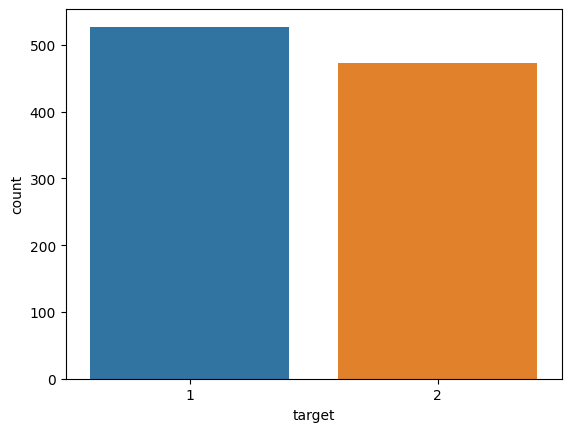

In [9]:
import seaborn as sns
display(data.groupby('target').nunique())
sns.countplot(x='target', data=data)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 375836 to 217538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  1000 non-null   int64 
 1   text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


In [11]:
data[data['target']==1].sample(5)

,target,text
524847,1,"Drinks are served in dirty plastic cups, servi..."
113902,1,Dillard's is utterly disgusting and trashy. Th...
482270,1,I went in to have a gun shipped here. I always...
449312,1,"On December 29, 2013, a Lucky Kitchen delivery..."
430568,1,Omg I never tasted such a horrible boba drink ...


In [12]:
# 2 na 0 - pozytywny wydźwięk

In [13]:
data = data[['text', 'target']]

data['target'].replace(2,0,inplace=True)
data.sample(5)

<ipython-input-13-e6dff7c88b17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].replace(2,0,inplace=True)


,text,target
509955,I can't speak to too many items on the menu si...,0
275939,"Good, authentic \""back-east\"" pies!\n\nUpdate:...",1
359246,"The fries were terrible, there are no free ref...",1
425895,"As old as I am now, I have fond memories of wa...",0
360130,Not my fav coffee place. Baristas tend to be q...,1


# Preprocessing

In [14]:
data['text'] = data['text'].apply(lambda x: x.lower())

In [15]:
re_url = re.compile(r"((www.[^\s]+)|(https?://[^\s]+))")
data['text'] = data['text'].apply(lambda x: re_url.sub('', x))

In [16]:
re_letters = re.compile(r"[^a-z\s']")
data['text'] = data['text'].apply(lambda x: re_letters.sub('', x))

### spacy.load

In [17]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [18]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['text'] = data['text'].apply(remove_stopwords)

In [19]:
data.drop_duplicates(subset='text', keep='first', inplace=True)

In [20]:
#### below is super-time-consuming

In [21]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])
data['text'] = data['text'].progress_apply(lemmatize)

100%|██████████| 1000/1000 [00:22<00:00, 44.23it/s]


In [22]:
# data.to_csv('sentiment_data_clean2.csv', sep='\t', index=False)

In [23]:
# data = pd.read_csv('sentiment_data_clean2.csv',sep='\t')
data

,text,target
375836,great service wait title,0
489278,good food bww wait greet minute host come chew...,1
178942,like lot yelper visit see man vs food nwe arri...,1
390863,thing great surrender outdoor view encore beac...,1
180054,go expect delicious meal food considerably wel...,1
...,...,...
363376,despite fantastic review refuse force hype aes...,1
171094,love fs spas huge fan fs restaurant range alli...,1
305510,donatos favorite chain pizza charlotte matter ...,0
39709,go time enjoy lot choose menu order individual...,0


Cloud of Words

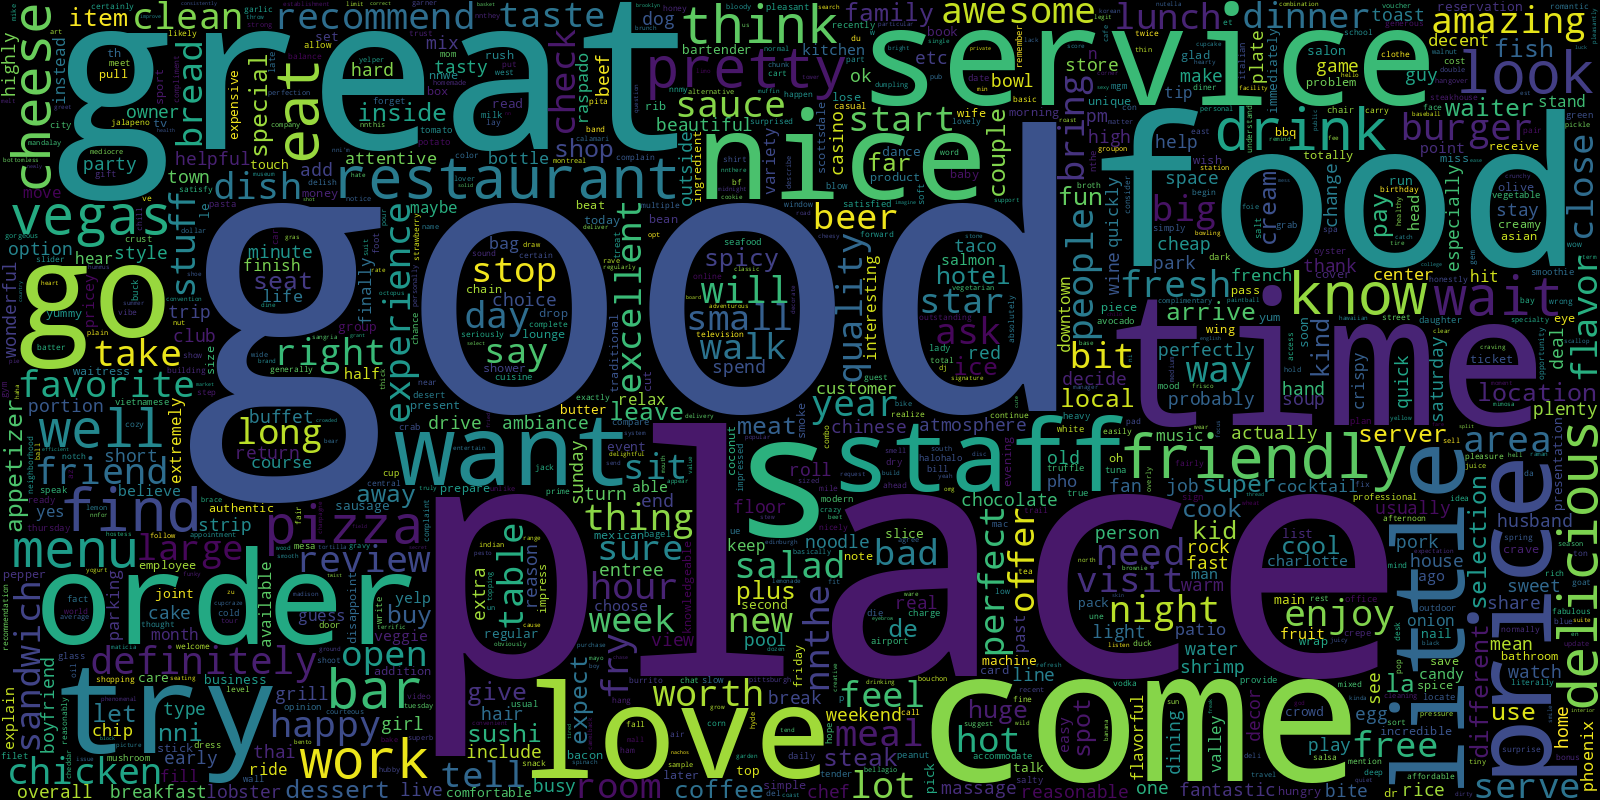

In [24]:
text_neg = ' '.join(data[data['target']==0]['text'])
wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

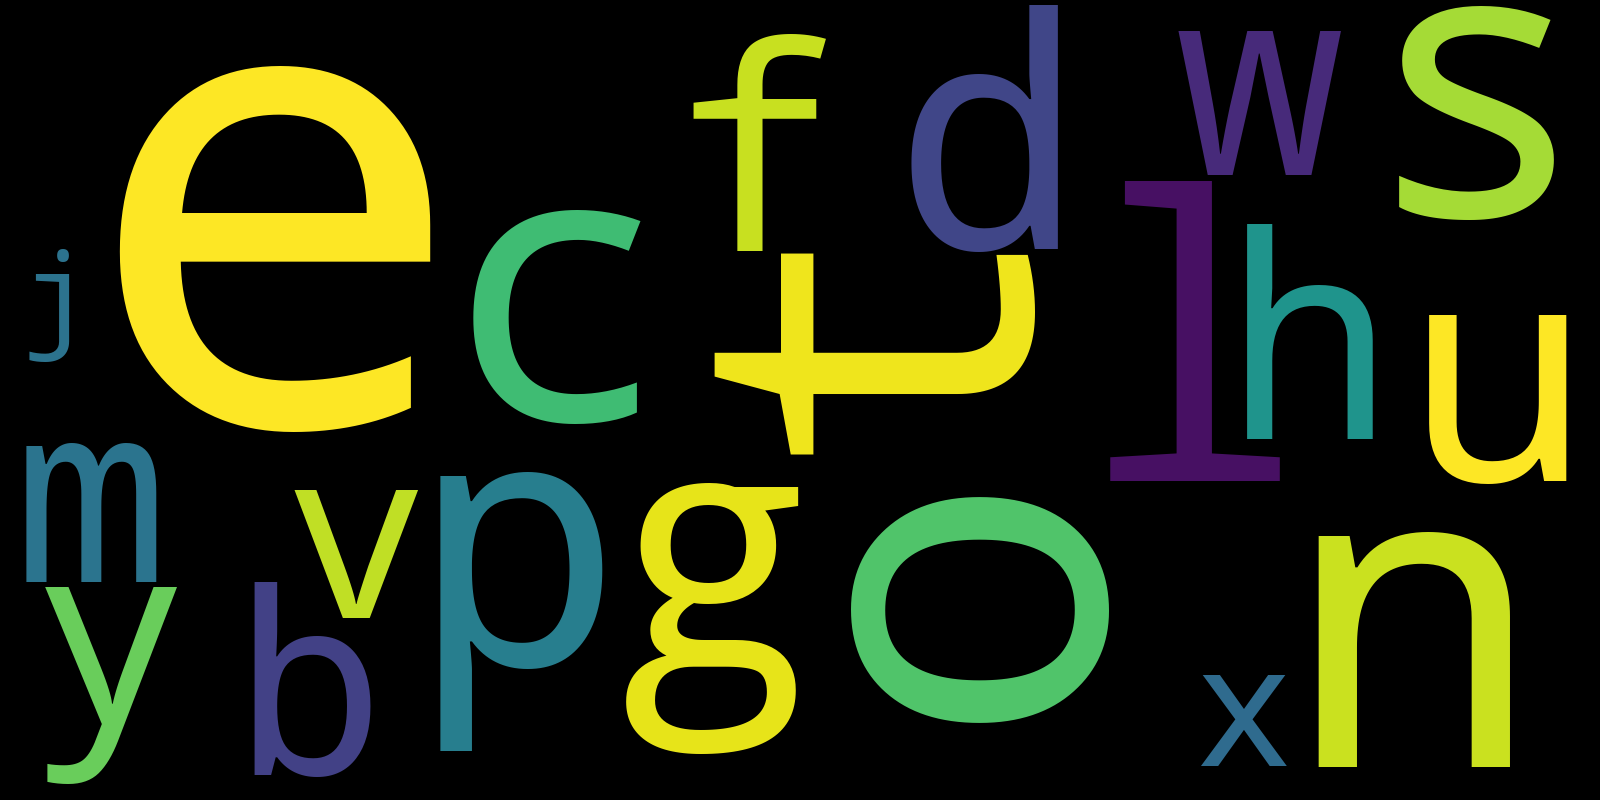

In [25]:
text_pos = ' '.join(str(data[data['target']==1]['text']))
wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

In [26]:
# data['text'].value_counts()

# Classification

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.1, stratify=data.target)

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000) # for paired values
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [29]:
len(vectorizer.get_feature_names_out())

54029

In [30]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [31]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

### Naive Bayes

In [32]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        47
           1       0.83      0.72      0.77        53

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100



# Podstawowa sieć RNN i Bert2




In [33]:
!pip install -U portalocker>=2.0.0


In [34]:
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torchdata.datapipes as dp
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [35]:
!pip install -U accelerate -q | grep -v 'already'
!pip install -U transformers -q | grep -v 'already'
!pip install -U datasets -q  | grep -v 'already'

In [36]:
import transformers
transformers.__version__

'4.36.2'

In [37]:
data.rename(columns={'target':'label'}, inplace=True)
data.sample(3)

,text,label
409079,previously give orient house star great food g...,1
62871,go fabulous freddy 's year place time frustrat...,1
13801,place idea brave bullet wound maybe hard core ...,1


In [38]:
from datasets import Dataset

dataset_ = Dataset.from_pandas(data)
dataset = dataset_.train_test_split(0.1)

### Fine-tuning

In [39]:
model_checkpoint = 'distilbert-base-uncased'
batch_size = 128

In [40]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [41]:
tokenizer("This is a sample")

{'input_ids': [101, 2023, 2003, 1037, 7099, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [42]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
eval_ds = dataset['test'].map(process)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


In [43]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [45]:
from datasets import load_metric
import numpy as np

metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

<ipython-input-45-35f6af1b57cb>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'sst2')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [46]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [47]:
trainer.evaluate([train_ds[0]])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7091845870018005,
 'eval_accuracy': 0.0,
 'eval_runtime': 1.3449,
 'eval_samples_per_second': 0.744,
 'eval_steps_per_second': 0.744}

In [48]:
# trainer.train()

In [49]:
trainer.model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# BERT z dofitowanym gotowym tokenizatorem

In [50]:
!pwd
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP')

/content/drive/MyDrive/Colab Notebooks/NLP
Mounted at /content/drive


In [51]:
import torch

SEED = 42

# seed dla PyTorch
torch.manual_seed(SEED)
if torch.cuda.is_available():
 torch.cuda.manual_seed(SEED)
 torch.cuda.manual_seed_all(SEED)
 torch.backends.cudnn.deterministic = True
 torch.backends.cudnn.benchmark = False

In [52]:
from transformers import DistilBertTokenizer, DistilBertModel,  RobertaModel, RobertaTokenizer
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time

In [53]:
import csv

def read_tsv(filename):
 data = []

 with open(filename, 'r', encoding='utf-8') as f:
  reader = csv.reader(f, delimiter='\t')
  for row in reader:
    data.append(tuple(row))

 return data

filename = "sentiment_data_clean2.csv"
data_list = read_tsv(filename)
data_list[0]

('text', 'target')

In [54]:
split_ratio = 0.2
n_train = len(data_list)
n_test = int(n_train * split_ratio)
n_train = n_train - n_test
train_data, test_data = random_split(data_list, [n_train, n_test])

In [55]:
label_pipeline = lambda x: 1 if x == '1' else 0

def collate_batch(batch):
 label_list, text_list = [], []
 for (_text, _label) in batch:
  label_list.append(label_pipeline(_label))
  text_list.append(_text)
 return torch.tensor(label_list, dtype=torch.float32), text_list

In [56]:
batch_size = 64

val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# import torch

# class RNN(nn.Module):

#   def __init__(self, hidden_dim, output_dim):
#     super().__init__()


#     # self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') #roberta-base , t5-small
#     # self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased') #distilbert-base-uncased


#     self.tokenizer =    RobertaTokenizer.from_pretrained('roberta-base') #roberta-base , t5-small
#     self.distilbert2 =    RobertaTokenizer.from_pretrained('roberta-base') #distilbert-base-uncased

#     embedding_dim = self.distilbert2.config.hidden_size
#     # embedding_dim = model.config.hidden_size

#     self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
#     self.fc = nn.Linear(hidden_dim, output_dim)

#   def forward(self, text, text_length=None):
#     inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512, return_length=True)
#     attention_mask = inputs['attention_mask'].to(device)
#     input_ids = inputs['input_ids'].to(device)

#     with torch.no_grad():
#       embedded = self.distilbert2(input_ids, attention_mask=attention_mask).last_hidden_state

#     outputs, hidden = self.rnn(embedded)
#     return self.fc(hidden.squeeze(0))

In [59]:
# hidden_dim = 256
# output_dim = 1

# model = RNN(hidden_dim, output_dim)

In [60]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel

class RNN(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()

        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        embedding_dim = self.roberta.config.hidden_size

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_length=None):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512, return_attention_mask=True)
        attention_mask = inputs['attention_mask'].to(self.roberta.device)
        input_ids = inputs['input_ids'].to(self.roberta.device)

        with torch.no_grad():
            embedded = self.roberta(input_ids, attention_mask=attention_mask)[0]

        outputs, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))

# Define the dimensions
hidden_dim = 256
output_dim = 1

# Create the model instance
model = RNN(hidden_dim, output_dim)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
def count_parameters(model):
 return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model ma {count_parameters(model):,} parametrów')

Model ma 124,908,545 parametrów


In [62]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [63]:
def binary_accuracy(preds, y):
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()

  for batch in iterator:
    labels, texts = batch
    labels = labels.to(device)
    optimizer.zero_grad()

    predictions = model(texts).squeeze(1)
    loss = criterion(predictions, labels)
    acc = binary_accuracy(predictions, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()

  with torch.no_grad():
    for batch in iterator:
      labels, texts = batch
      labels = labels.to(device)

      predictions = model(texts).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'rnn-model.pt')

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
# Simple RNN

In [ ]:
!pip install -U portalocker | grep -v 'already'
!python -m spacy download en_core_web_sm  | grep -v 'already'


In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for _, text in data_iter:
    return tokenizer(text)

In [ ]:
from torchtext.datasets import IMDB
from torchtext.vocab import build_vocab_from_iterator


train_iter, test_iter = IMDB(split=('train', 'test'))

MAX_TOKENS = 25000

vocab = build_vocab_from_iterator( [yield_tokens(train_iter)], specials=['<unk>'], max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else 0

def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []
  for _text, _label in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  text_list = pad_sequence(text_list, batch_first=True)
  return label_list, text_list, lenghts

In [ ]:
batch_size = 64
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
      super().__init__()
      self.embedding = nn.Embedding(input_dim, embedding_dim)
      self.rnn = nn.RNN(embedding_dim, hidden_dim)
      self.lstm = nn.LSTM(
          embedding_dim,
          hidden_dim,
          num_layers=3,
          bidirectional=True,
          dropout=0.3
      )
      self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, text, text_length):
      embedded = self.embedding(text)
      packed_embedded = pack_padded_sequence(embedded, text_length.cpu(), batch_first=True, enforce_sorted=False)
      packed_output, hidden = self.rnn(packed_embedded)
      # packed_output, hidden = self.lstm(packed_embedded)

      output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)

      return self.fc(hidden.squeeze(0))

In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model ma {count_parameters(model):,} parametrów')

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in dataloader:
      #label_list, text_list, lenghts
      labels, texts, lengths = batch
      texts, labels = texts.to(device), labels.to(device)
      optimizer.zero_grad()

      predictions = model(texts, lengths).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
        labels, texts, lengths = batch
        texts, labels = texts.to(device), labels.to(device)

        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_dataloader


In [ ]:
N_EPOCHS = 6
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, test_dataloader, criterion)

  end_time = time.time()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'rnn_model.pt')

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')